### Model-Free Reinforcement Learning: SARSA & Q-Learning

Dans cette partie, nous considérons un cadre où la dynamique de l’environnement n’est pas connue.  
L’agent apprend directement la fonction de valeur d’action $Q(s,a)$ à partir de son interaction avec l’environnement.

Nous étudions deux algorithmes fondamentaux : **SARSA** et **Q-learning**.

---

### SARSA (on-policy)

SARSA met à jour la valeur selon la transition réellement observée :

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma Q(s', a') - Q(s,a) \right)
$$

où :
- $a'$ est l’action effectivement choisie dans l’état $s'$ selon la politique courante,
- $\alpha$ est le taux d’apprentissage,
- $\gamma$ est le facteur d’actualisation.

L’algorithme apprend donc la valeur de la politique qu’il est en train d’exécuter.

---

### Q-learning (off-policy)

Q-learning met à jour la valeur en utilisant l’action optimale théorique dans l’état suivant :

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma \max_{a'} Q(s', a') - Q(s,a) \right)
$$

La mise à jour repose sur le maximum des valeurs possibles dans l’état suivant, indépendamment de l’action réellement exécutée.

---

### Différence fondamentale

- **SARSA** utilise $Q(s', a')$ avec $a' \sim \pi$
- **Q-learning** utilise $\max_{a'} Q(s', a')$

La première approche est **on-policy**, la seconde est **off-policy**.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
# ici on passe sur un environnement offert par gymnasium pour voir la différence entre SARSA et Q-learning 
# On choisit l'envirronment FrozenLake, qui est un environnement de grille où l'agent doit atteindre un objectif 
# tout en évitant les trous, et où les actions ont une certaine probabilité de ne pas être exécutées comme prévu, 
# ce qui introduit de la stochasticté dans l'environnement (is_slippery = True).

In [17]:
def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    else:
        return np.argmax(Q[state])
    
# simple focntion qui définit uen politique epsilon-greedy à partir d'une fonction d'action-valeur Q,
# qui prend en entrée un état et retourne une action

In [18]:
alpha = 0.1 # paramètre d'apprentissage (learning rate) qui contrôle à quel point les nouvelles informations 
#remplacent les anciennes dans la mise à jour de la fonction d'action-valeur Q.
gamma = 0.99 # facteur de discount (discount factor) qui mesure l'importance des récompenses futures 
# par rapport aux récompenses immédiates.

# on prend un espilon qui décroit au fil des épisodes pour favoriser l'exploration au début et l'exploitation plus tard
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9995
epsilon = epsilon_start

n_episodes = 30000 # nombre d'épisodes d'entraînement, c'est à dire le nombre de fois que
# l'agent va interagir avec l'environnement

In [19]:
env = gym.make("FrozenLake-v1", is_slippery=True)

# on a ici un environnement avec des états discrets, donc on peut utiliser une table Q 
# pour stocker les valeurs d'action-valeur, qui est une matrice de taille (n_states, n_actions) 
# où n_states est le nombre d'états dans l'environnement et n_actions est le nombre d'actions possibles.
n_states = env.observation_space.n
n_actions = env.action_space.n

Q = np.zeros((n_states, n_actions)) #initialisation de la table Q à zéro, ce qui signifie que l'agent 
# n'a aucune connaissance préalable sur les valeurs d'action-valeur au début de l'entraînement.

rewards = []

for episode in range(n_episodes):
    
    state, _ = env.reset() # réinitialisation de l'environnement à chaque épisode, 
    # ce qui retourne l'état initial et d'autres informations
    done = False
    total_reward = 0
    
    while not done: #tant que l'on est aps arrivé à un état terminal, on continue à interagir avec l'environnement
        
        action = epsilon_greedy(Q, state, epsilon) # sélection de l'action à partir de la politique epsilon-greedy
        
        next_state, reward, terminated, truncated, _ = env.step(action) # exécution de l'action dans l'environnement,
        # ce qui retourne le nouvel état, la récompense obtenue, et des indicateurs de terminaison de l'épisode 
        # (terminated et truncated). C'est gymnasium qui a codé la classe. 

        done = terminated or truncated # vérifie si l'épisode est terminé, soit parce que l'agent a atteint 
        # un état terminal (terminated) soit parce que le nombre maximum de pas a été atteint (truncated)
        
        Q[state, action] += alpha * (
            reward + gamma * np.max(Q[next_state]) - Q[state, action]
        )
        #mise a jour de Q learning qui utilise le max sur les actions du prochain état pour calculer la 
        # cible de la mise à jour, et pas l'action effectivement choisie (off policy)
        
        state = next_state # mise à jour de l'état courant pour la prochaine itération de la boucle
        total_reward += reward # mise à jour du gain total de l'épisode en ajoutant la récompense obtenue à chaque étape
        # seulement utile pour le plot

        epsilon = max(epsilon_end, epsilon * epsilon_decay) # mise à jour de epsilon 
        
    rewards.append(total_reward)


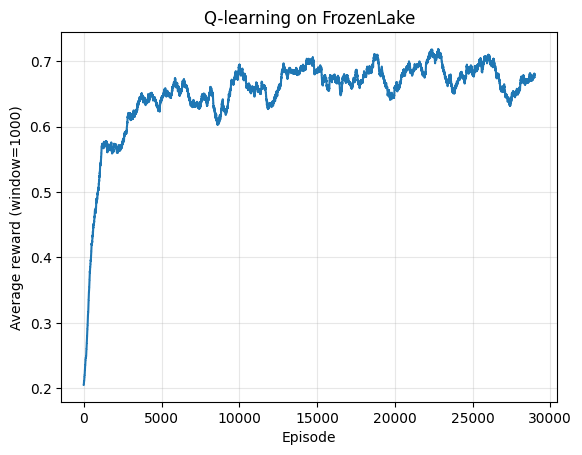

In [20]:
window = 1000 # taille de la fenêtre pour le calcul de la moyenne mobile, 
# qui correspond au nombre d'épisodes sur lesquels on calcule la moyenne des récompenses pour lisser 
# les résultats et mieux visualiser les tendances d'apprentissage de l'agent au fil du temps.
moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')

plt.plot(moving_avg)
plt.grid(alpha=0.3)
plt.xlabel("Episode")
plt.ylabel("Average reward (window={})".format(window))
plt.title("Q-learning on FrozenLake")
plt.show()

In [21]:
epsilon = epsilon_start
#Il ne faut pas oublier de réinitialiser epsilon pour l'entraînement de SARSA, 
# sinon on risque d'avoir une politique trop exploitante dès le début, 
# ce qui peut nuire à l'apprentissage de l'agent.

Q_sarsa = np.zeros((n_states, n_actions))
# on réinitialise la table Q pour SARSA

rewards_sarsa = [] # et le reward pour SARSA

for episode in range(n_episodes):
    
    state, _ = env.reset()
    action = epsilon_greedy(Q_sarsa, state, epsilon)
    
    done = False
    total_reward = 0
    
    while not done:
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        next_action = epsilon_greedy(Q_sarsa, next_state, epsilon)
        
        # Update SARSA
        Q_sarsa[state, action] += alpha * (
            reward + gamma * Q_sarsa[next_state, next_action]
            - Q_sarsa[state, action]
        ) # c'est létape qui diffère ici, car SARSA utilise l'action effectivement choisie (next_action) 
        # pour calculer la cible de la mise à jour, ce qui rend l'algorithme on-policy.
        
        state = next_state
        action = next_action 
        total_reward += reward #seulement utile pour le plot 
    
    rewards_sarsa.append(total_reward)
    
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

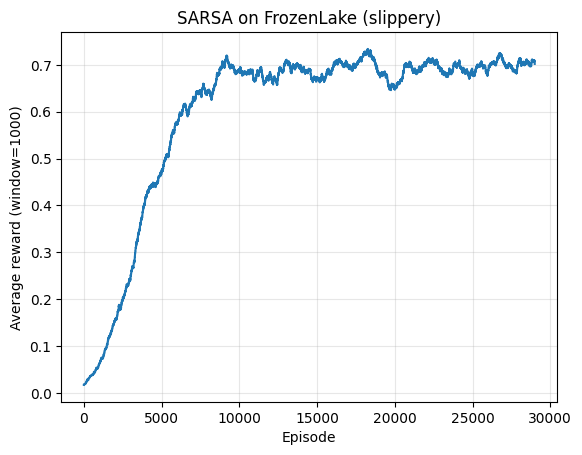

In [22]:
window = 1000
moving_avg_sarsa = np.convolve(rewards_sarsa,np.ones(window)/window,mode='valid')

plt.plot(moving_avg_sarsa)
plt.grid(alpha=0.3)
plt.xlabel("Episode")
plt.ylabel(f"Average reward (window={window})")
plt.title("SARSA on FrozenLake (slippery)")
plt.show()

On peut ici utiliser Gymnasium, car nous n’avons pas besoin de connaître les probabilités de transition de l’environnement. Il suffit de pouvoir interagir avec celui-ci afin de collecter des transitions.

On remarque que les deux algorithmes présentent des performances similaires sur cet exemple.